In [1]:

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


#testing out git version control

[nltk_data] Downloading package punkt to /Users/mary/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mary/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mary/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/mary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
import nltk
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_curve,f1_score,auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [3]:

# Set seed for reproduceable results
np.random.seed(500)
# Read in to Pandas DataFrame and drop the first row(which contained column names as I have assigned new names)
reviews = pd.read_csv(r"rt_reviews.csv", names = ['target', 'review'], encoding = 'latin-1')
reviews = reviews.iloc[1:]

/Users/mary/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Standardize target data types to numeric
for i in range(reviews.shape[0]):
    if(reviews['target'].values[i] == '0'):
        reviews['target'].values[i] = 0
    elif(reviews['target'].values[i] == '1'):
        reviews['target'].values[i] = 1
for i in range(reviews.shape[0]):
    if(isinstance(reviews['target'].values[i],str)):
        print("Caught: ",reviews['target'].values[i])
    if(reviews['target'].values[i] != 0 and reviews['target'].values[i] != 1):
        print("Error")

In [5]:
# Choose number of samples to use
#reviews = reviews.iloc[:1000] #commented out to use all samples

In [6]:
# Remove and row where either datafield is blank, no rows contained blank data so the shape remains 480000,2 
reviews.dropna(inplace = True)
reviews.shape

(480000, 2)

In [7]:
# Convert all text to lowercase
reviews['review'] = [entry.lower() for entry in reviews['review']]

In [8]:
# Tokenize each review: this process converts each review into a set of words. 
reviews['review'] = [word_tokenize(entry) for entry in reviews['review']]

In [9]:
################# Lemmatizing ##############  ##DONT RUN W/ ALL SAMPLES

# Creating tags so that lemmatizer can understand verbs from nouns from adjectives 
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(reviews['review']):
    index = index+1 # Index seems to off by one, this fixes it
    # Words that follow the rules will end up in this list
    Final_words = []
    
    word_Lemmatized = WordNetLemmatizer()
    
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha() and wordnet.synsets(word):
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
        reviews.loc[index, 'lemmatized_words'] = str(Final_words)

In [9]:
################ Unaltered Words ############

for index, entry in enumerate(reviews['review']):
    index = index + 1
    Final_words = []
        
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha() and wordnet.synsets(word):
            word_Final = word  #This is where a stemmer would go
            Final_words.append(word_Final)
        reviews.loc[index, 'unaltered_words'] = str(Final_words)        

In [11]:
############### Stemming Words ###############  ##DONT RUN W/ ALL SAMPLES

for index, entry in enumerate(reviews['review']):
    index = index + 1
    Final_words = []
        
    word_Stemmer = PorterStemmer()
        
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha() and wordnet.synsets(word):
            word_Final = word_Stemmer.stem(word)  #This is where a stemmer would go
            Final_words.append(word_Final)
        reviews.loc[index, 'stemmed_words'] = str(Final_words)        

In [10]:
reviews

,target,review,unaltered_words
1,1,"[manakamana, does, n't, answer, any, questions...","['answer', 'questions', 'yet', 'makes', 'point..."
2,1,"[wilfully, offensive, and, powered, by, a, che...","['wilfully', 'offensive', 'powered', 'machismo..."
3,0,"[it, would, be, difficult, to, imagine, materi...","['difficult', 'imagine', 'material', 'wrong', ..."
4,0,"[despite, the, gusto, its, star, brings, to, t...","['despite', 'gusto', 'star', 'brings', 'role',..."
5,0,"[if, there, was, a, good, idea, at, the, core,...","['good', 'idea', 'core', 'film', 'buried', 'un..."
...,...,...,...
479996,0,"[zemeckis, seems, unable, to, admit, that, the...","['seems', 'unable', 'admit', 'motion', 'captur..."
479997,1,"[movies, like, the, kids, are, all, right, --,...","['movies', 'like', 'kids', 'right', 'beautiful..."
479998,0,"[film-savvy, audiences, soon, will, catch, ont...","['audiences', 'soon', 'catch', 'attempts', 'ea..."
479999,1,"[an, odd, yet, enjoyable, film, .]","['odd', 'yet', 'enjoyable', 'film']"


In [21]:
# Create Train and Test splits 
test_s = .15
train_x, test_x, train_y, test_y = model_selection.train_test_split(reviews['unaltered_words'], 
                                                                    reviews['target'], test_size=test_s)

In [22]:
print("\ntrain_x Shape: ", train_x.shape)
print("\ntrain_y Shape: ", train_y.shape)
print("\ntest_x Shape: ", test_x.shape)
print("\ntest_y Shape: ", test_y.shape)


train_x Shape:  (408000,)

train_y Shape:  (408000,)

test_x Shape:  (72000,)

test_y Shape:  (72000,)


In [23]:
# Encode target data
Encoder = LabelEncoder()
train_y = Encoder.fit_transform(train_y)
test_y = Encoder.fit_transform(test_y)

In [24]:
###### Term Frequency-Inverse Document Frequency #######
max_f = 100000
Tfidf_vect = TfidfVectorizer(stop_words='english', max_features=max_f)
Tfidf_vect.fit_transform(reviews['unaltered_words'])
train_x_Tfidf = Tfidf_vect.transform(train_x)
test_x_Tfidf = Tfidf_vect.transform(test_x)
#print(Tfidf_vect.vocabulary_)
len(Tfidf_vect.vocabulary_)

47350

In [15]:
##### Bag of Words #######
max_f = 100000
#ngram_range default is (1,1)
#ngram_range(1,1) -> uni-gram
#ngram_range(2,2) -> bi-gram
#ngram_range(3,3) -> tri-gram
#ngram_range(1,2) -> uni, bi-grams -> BEST SO FAR
Count_vect = CountVectorizer(stop_words='english', max_features=max_f, ngram_range=(1,2))
Count_vect.fit_transform(reviews['unaltered_words'])
train_x_Count = Count_vect.transform(train_x)
test_x_Count = Count_vect.transform(test_x)
#print(Tfidf_vect.vocabulary_)
len(Count_vect.vocabulary_)

100000

In [16]:
# Python dictionary of various test results: 

# These test results use a data set that contains no english words, is lemmatized

zach_test_results = {
    # Max features percentages are out of 36131(which is max features when
    # full 480000 sampels and non english words removed, .15 test size)
    
    # 9033 features 
    "max-features_.25" : {"accuracy" : 0.7748 , "f1-avg" : 0.775 },
    
    # 18066
    "max-features_.50" : {"accuracy" : 0.7810 , "f1-avg" : 0.78 },
    
    # 27120
    "max-features_.75" : {"accuracy" : 0.7841 , "f1-avg" : 0.78 },
    
    #30711
    "max-features_.85" : {"accuracy" : 0.7845, "f1-avg" : 0.785 },
    
    # 34324
    "max-features_.95" : {"accuracy" : 0.7845, "f1-avg" : 0.785},
    
    # 36131
    "max-features_1.00" : {"accuracy" : 0.7845, "f1-avg" : 0.785},
    
    
    # Removing words with low information 
    
    # results in only 6027 features meaning the majority are below 100 df
    "min_df_100" : {"accuracy" : 0.7673 , "f1-avg": 0.77 },
    
    # results in 9060 feautures
    "min_df_50" : {"accuracy" : 0.7748 , "f1-avg": 0.775 },
    
    # results in 18458 features
    "min_df_10" : {"accuracy" : 0.7811 , "f1-avg": 0.78},
    
    # results in 23402 features
    "min_df_5" : {"accuracy" : 0.7833, "f1-avg": 0.78 },
    
    #results in 36131 features
    "min_df_1" : {"accuracy" : 0.7845, "f1-avg": 0.785 },
    
    #results in 36131 features
    "min_df_0" : {"accuracy" : 0.7845, "f1-avg": 0.785}, 
    
    # when non english features taken out only 36131 features
    # when non english words not taken out 69635
    "max-samples-norestriction-wo-nonenglish-test.15": {"accuracy" : 0.7845, "f1-avg" : 0.785},
    "max-samples-norestriction-w-nonenglish-test.15": {"accuracy" : 0.79275, "f1-avg" : 0.79},
    
    # trained with 480K samples and titles removed
    #36131 features
    "lemma" : {"accuracy" : .7833 , 'f1-avg' : .78},
    #24835 features 
    "stem" : {"accuracy" : .7792 , 'f1-avg' : .78},
    #47506 features 
    "unaltered" : {"accuracy" : .7945, 'f1-avg' : .795}, 
    
    # trained with 10K samples and titles removed
    #12775 features
    "lemma" : {"accuracy" : .708 , 'f1-avg' : .705},
    #10402 features 
    "stem" : {"accuracy" : .7153 , 'f1-avg' : .715},
    #15973 f 
    "unaltered" : {"accuracy" : .7093, 'f1-avg' : .71}, 
    
     # trained with 100K samples and titles removed
    #26600 features
    "lemma" : {"accuracy" : .77507 , 'f1-avg' : .775},
    #19459 features 
    "stem" : {"accuracy" : .762 , 'f1-avg' : .76},
    #34772 f 
    "unaltered" : {"accuracy" : .7752, 'f1-avg' : .78}, 
    
    # best performance so far, but test split may be too small. 
    "unaltered_w/_.05test" : {"accuracy" : .796, 'f1-avg' : .8}
}

In [17]:
###### Term Frequency-Inverse Document Frequency #######
nb = naive_bayes.MultinomialNB()
nb.fit(train_x_Tfidf, train_y)

# predict the target on validation data
pred_nb = nb.predict(test_x_Tfidf)

# output accuracy just to show it works
print("Accuracy: ", accuracy_score(pred_nb, test_y))
nb_probs = nb.predict_proba(test_x_Tfidf)
nb_probs = nb_probs[:,1]
print(classification_report(test_y, pred_nb, labels=[0,1]))
# svm = SVC(probability=True)
# svm.fit(train_x_Tfidf, train_y)
# pred_svm = svm.predict(test_x_Tfidf)
# print("Accuracy: ", accuracy_score(pred_svm, test_y))

Accuracy:  0.7889027777777777
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     35977
           1       0.79      0.79      0.79     36023

    accuracy                           0.79     72000
   macro avg       0.79      0.79      0.79     72000
weighted avg       0.79      0.79      0.79     72000



In [25]:
# Python dictionary of various test results: 


mary_test_results = {
    # full 480000 sampels and non english words removed, .15 test size)
    
    # (1,1)->only unigrams
    "only uni-grams" : {"accuracy" : 0.7871 , "f1-avg" : 0.79 },
    
    # (2,2)-> only bigrams
    "only bi-grams" : {"accuracy" : 0.7294 , "f1-avg" : 0.73 },
    
    # (3,3) -> only trigrams
    "only tri-grams" : {"accuracy" : 0.5991 , "f1-avg" : 0.54 },
    
    #(4,4) -> only quad-grams
    "only quad-grams" : {"accuracy" : 0.5746, "f1-avg" : 0.48 },
    
    # (1,2) -> uni and bi-grams -> BEST SO FAR
    "uni-grams, bi-grams" : {"accuracy" : 0.8055, "f1-avg" : 0.81},
    
    # (1,3) -> uni, bi, and tri-grams
    "uni-grams, bi-grams, tri-grams" : {"accuracy" : 0.8047, "f1-avg" : 0.80},
    
    # (1,4) -> uni, bi, tri, and quad-grams
    "uni-grams, bi-grams, tri-grams, quad-grams" : {"accuracy" : 0.8049, "f1-avg" : 0.80},
}

In [26]:
###### Bag of Words Frequency #######
nb = naive_bayes.MultinomialNB()
nb.fit(train_x_Count, train_y)

# predict the target on validation data
pred_nb = nb.predict(test_x_Count)

# output accuracy just to show it works
print("Accuracy: ", accuracy_score(pred_nb, test_y))
nb_probs = nb.predict_proba(test_x_Count)
nb_probs = nb_probs[:,1]
print(classification_report(test_y, pred_nb, labels=[0,1]))
# svm = SVC(probability=True)
# svm.fit(train_x_Count, train_y)
# pred_svm = svm.predict(test_x_Count)
# print("Accuracy: ", accuracy_score(pred_svm, test_y))

Accuracy:  0.5002222222222222
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     35753
           1       0.50      0.50      0.50     36247

    accuracy                           0.50     72000
   macro avg       0.50      0.50      0.50     72000
weighted avg       0.50      0.50      0.50     72000



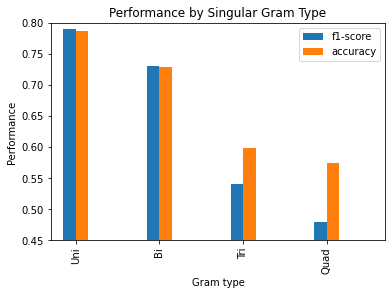

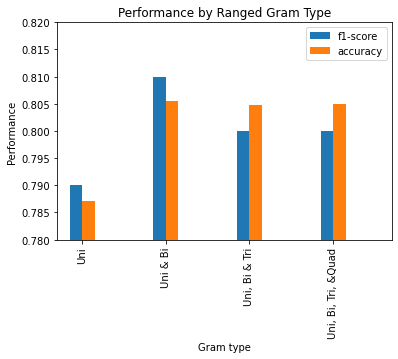

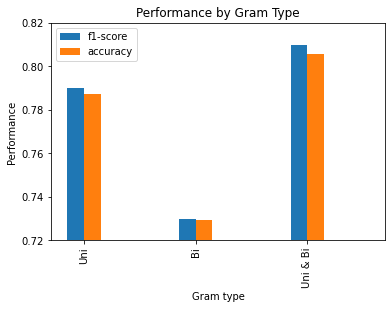

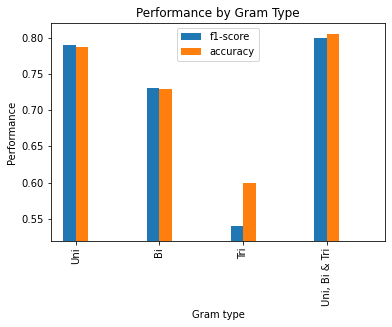

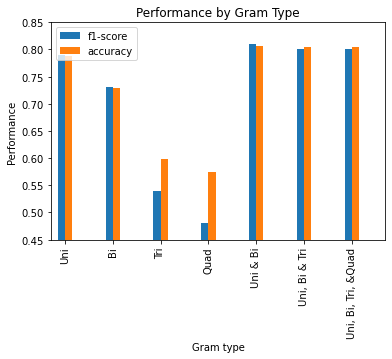

In [48]:
################ Graphs of the Different grams for Bag of Words ############

#performed on all 100,000 examples w/ unaltered words

## only singular grams
width = .3
pltData = pd.DataFrame({ 
'accuracy': [.7871, .7294, .5991, .5746], 
'f1-score' : [.79,.73,.54,.48]})

pltData[['f1-score', 'accuracy']].plot(kind = 'bar', width = width)

ax = plt.gca()

plt.xlim([-width, len(pltData['accuracy'])-width])

ax.set_ylim([.45, .8])
ax.set_xticklabels(('Uni', 'Bi', 'Tri','Quad'))
ax.legend(labels = ['f1-score', 'accuracy'])
ax.set_title("Performance by Singular Gram Type")
ax.set_ylabel('Performance')
ax.set_xlabel('Gram type')

plt.show()



#only ranged grams
width = .3
pltData = pd.DataFrame({ 
'accuracy': [.7871, .8055, .8047, .8049], 
'f1-score' : [.79,.81,.80,.80]})

pltData[['f1-score', 'accuracy']].plot(kind = 'bar', width = width)

ax = plt.gca()

plt.xlim([-width, len(pltData['accuracy'])-width])

ax.set_ylim([.78, .82])
ax.set_xticklabels(('Uni', 'Uni & Bi', 'Uni, Bi & Tri','Uni, Bi, Tri, &Quad'))
ax.legend(labels = ['f1-score', 'accuracy'])
ax.set_title("Performance by Ranged Gram Type")
ax.set_ylabel('Performance')
ax.set_xlabel('Gram type')

plt.show()



#looking at uni-bi grams
width = .3
pltData = pd.DataFrame({ 
'accuracy': [.7871, .7294, .8055], 
'f1-score' : [.79, .73, .81]})

pltData[['f1-score', 'accuracy']].plot(kind = 'bar', width = width)

ax = plt.gca()

plt.xlim([-width, len(pltData['accuracy'])-width])

ax.set_ylim([.72, .82])
ax.set_xticklabels(('Uni', 'Bi', 'Uni & Bi'))
ax.legend(labels = ['f1-score', 'accuracy'])
ax.set_title("Performance by Gram Type")
ax.set_ylabel('Performance')
ax.set_xlabel('Gram type')

plt.show()



#looking at uni-tri grams
width = .3
pltData = pd.DataFrame({ 
'accuracy': [.7871, .7294, .5991, .8047], 
'f1-score' : [.79, .73, .54, .80]})

pltData[['f1-score', 'accuracy']].plot(kind = 'bar', width = width)

ax = plt.gca()

plt.xlim([-width, len(pltData['accuracy'])-width])

ax.set_ylim([.52, .82])
ax.set_xticklabels(('Uni', 'Bi', 'Tri', 'Uni, Bi & Tri'))
ax.legend(labels = ['f1-score', 'accuracy'])
ax.set_title("Performance by Gram Type")
ax.set_ylabel('Performance')
ax.set_xlabel('Gram type')

plt.show()


#looking at all grams
width = .3
pltData = pd.DataFrame({ 
'accuracy': [.7871, .7294, .5991, .5746, .8055, .8047, .8049], 
'f1-score' : [.79, .73, .54, .48, .81, .80, .80]})

pltData[['f1-score', 'accuracy']].plot(kind = 'bar', width = width)

ax = plt.gca()

plt.xlim([-width, len(pltData['accuracy'])-width])

ax.set_ylim([.45, .85])
ax.set_xticklabels(('Uni', 'Bi', 'Tri', 'Quad', 'Uni & Bi', 'Uni, Bi & Tri', 'Uni, Bi, Tri, &Quad'))
ax.legend(labels = ['f1-score', 'accuracy'])
ax.set_title("Performance by Gram Type")
ax.set_ylabel('Performance')
ax.set_xlabel('Gram type')

plt.show()

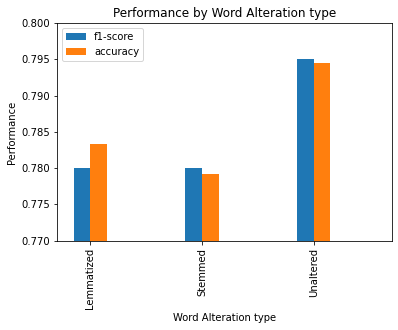

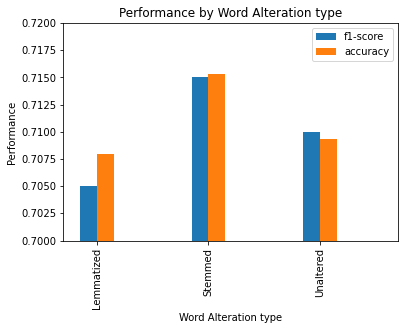

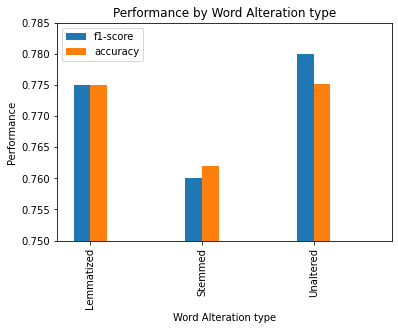

In [20]:

############### Lemma vs Stem vs Unaltered 480k ###################

# performed on 480k samples with non english words removed
width = .3
pltData = pd.DataFrame({ 
'accuracy': [.7833, .7792, .7945], 
'f1-score' : [.78, .78,.795]})

pltData[['f1-score', 'accuracy']].plot(kind = 'bar', width = width)

ax = plt.gca()

plt.xlim([-width, len(pltData['accuracy'])-width])

ax.set_ylim([.77, .8])
ax.set_xticklabels(('Lemmatized', 'Stemmed', 'Unaltered'))
ax.legend(labels = ['f1-score', 'accuracy'])
ax.set_title("Performance by Word Alteration type")
ax.set_ylabel('Performance')
ax.set_xlabel('Word Alteration type')


plt.show()

############### Lemma vs Stem vs Unaltered 10k ###################

width = .3
pltData = pd.DataFrame({ 
'accuracy': [.708, .7153, .7093], 
'f1-score' : [.705, .715,.71]})

pltData[['f1-score', 'accuracy']].plot(kind = 'bar', width = width)

ax = plt.gca()

plt.xlim([-width, len(pltData['accuracy'])-width])

ax.set_ylim([.7, .72])
ax.set_xticklabels(('Lemmatized', 'Stemmed', 'Unaltered'))
ax.legend(labels = ['f1-score', 'accuracy'])
ax.set_title("Performance by Word Alteration type")
ax.set_ylabel('Performance')
ax.set_xlabel('Word Alteration type')


plt.show()


############### Lemma vs Stem vs Unaltered 100k ###################

width = .3
pltData = pd.DataFrame({ 
'accuracy': [.7751, .762, .7752], 
'f1-score' : [.775, .76,.78]})

pltData[['f1-score', 'accuracy']].plot(kind = 'bar', width = width)

ax = plt.gca()

plt.xlim([-width, len(pltData['accuracy'])-width])

ax.set_ylim([.75, .785])
ax.set_xticklabels(('Lemmatized', 'Stemmed', 'Unaltered'))
ax.legend(labels = ['f1-score', 'accuracy'])
ax.set_title("Performance by Word Alteration type")
ax.set_ylabel('Performance')
ax.set_xlabel('Word Alteration type')


plt.show()

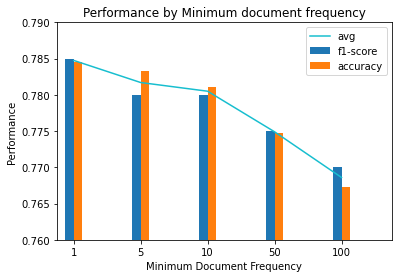

In [21]:
############### Alternative Plot for minumum document frequency ###################

width = .25 
pltData = pd.DataFrame({ 
'accuracy': [.7845, .7833, .7811, .7748, .7673], 
'f1-score' : [.785, .78, .78, .775, .77], 
'avg' : [.78475, .7817, .7805, .7749, .7686]})

pltData[['f1-score', 'accuracy']].plot(kind = 'bar', width = width)
pltData['avg'].plot(color = "tab:cyan")

ax = plt.gca()

plt.xlim([-width, len(pltData['accuracy'])-width])

ax.set_ylim([.76, .79])
ax.set_xticklabels(('1', '5', '10', '50', '100'))
ax.legend(labels = ['avg','f1-score', 'accuracy'])
ax.set_title("Performance by Minimum document frequency")
ax.set_ylabel('Performance')
ax.set_xlabel('Minimum Document Frequency')

plt.show()

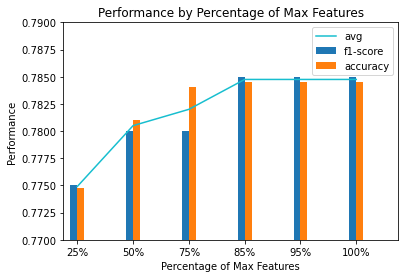

In [22]:
############### Plot for Max features ###################

width = .25 
pltData = pd.DataFrame({ 
'accuracy': [.7748, .7810, .7841, .7845, .7845, .7845], 
'f1-score' : [.775, .78, .78, .785, .785, .785], 
'avg' : [.7749, .7805, .7820, .78475, .78475, .78475]})

pltData[['f1-score', 'accuracy']].plot(kind = 'bar', width = width)
pltData['avg'].plot(color = "tab:cyan")

ax = plt.gca()

plt.xlim([-width, len(pltData['accuracy'])-width])

ax.set_ylim([.77, .79])
ax.set_xticklabels(('25%', '50%', '75%', '85%', '95%', '100%'))
ax.legend(labels = ['avg','f1-score', 'accuracy'])
ax.set_title("Performance by Percentage of Max Features")
ax.set_ylabel('Performance')
ax.set_xlabel('Percentage of Max Features')

plt.show()

In [ ]:
# First Attempt at classifier is Naive Bays 
#nbm = naive_bayes.MultinomialNB()
#nbm.fit(train_x_Tfidf, train_y)

#Bernoulli Naive Bayes
nbb = naive_bayes.BernoulliNB()
nbb.fit(train_x_Tfidf, train_y)

# predict the target on validation data
#pred_nbm = nbm.predict(test_x_Tfidf)
pred_nbb = nbb.predict(test_x_Tfidf)

# output accuracy just to show it works
print("NB Multinomial: Accuracy: ", accuracy_score(pred_nbm, test_y))
print("NB Bernoulli: Accuracy: ", accuracy_score(pred_nbb, test_y))

#svm = SVC(probability=True)
#svm.fit(train_x_Tfidf, train_y)
#pred_svm = svm.predict(test_x_Tfidf)
#print("SVM: Accuracy: ", accuracy_score(pred_svm, test_y))

In [ ]:
#Analysis

#Predict Probability
#nbm_probs = nbm.predict_proba(test_x_Tfidf)
#nbm_probs = nbm_probs[:,1]
nbb_probs = nbb.predict_proba(test_x_Tfidf)
nbb_probs = nbb_probs[:,1]
#svm_probs = svm.predict_proba(test_x_Tfidf)
#svm_probs = svm_probs[:,1]

#Classification Report
#print(classification_report(test_y, pred_nbm, labels=[0,1]))
print(classification_report(test_y, pred_nbb, labels=[0,1]))
#print(classification_report(test_y, pred_svm, labels=[0,1]))

#Calculate precision-recall
#precision_nbm, recall_nbm, thresholds_nbm = precision_recall_curve(test_y, nbm_probs)
precision_nbb, recall_nbb, thresholds_nbb = precision_recall_curve(test_y, nbb_probs)
#precision_svm, recall_svm, thresholds_svm = precision_recall_curve(test_y, svm_probs)

#Calculate F1
#f1_nbm = f1_score(test_y, pred_nbm)
f1_nbb = f1_score(test_y, pred_nbb)
#f1_svm = f1_score(test_y, pred_svm)

#Calculate precision recal auc
# auc_nb = auc(recall_nb, precision_nb)
# auc_svm = auc(recall_svm, precision_svm)

# summarize scores
print("Test Split: ", test_s)
print("Max Features: ", max_f)
#print('Naive-Bayes-Multinomial: f1=%.3f' % (f1_nbm))
#print("Accuracy: ", accuracy_score(pred_nbm, test_y))
print('Naive-Bayes-Bernoulli: f1=%.3f' % (f1_nbb))
print("Accuracy: ", accuracy_score(pred_nbb, test_y))
#print('Support Vector Machine: f1=%.3f' % (f1_svm))
#print("Accuracy: ", accuracy_score(pred_svm, test_y))


# plot the precision-recall curves
no_skill = len(test_y[test_y==1]) / len(test_y)
#pyplot.plot(recall_nbm, precision_nbm, marker='.', label='Naive-Bayes Multinomial')
pyplot.plot(recall_nbb, precision_nbb, marker='.', label='Naive-Bayes Bernoulli')
#pyplot.plot(recall_svm, precision_svm, marker='.', label='SVM')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

In [ ]:
#Learning curve
#svm_train_sizes, svm_train_scores, svm_valid_scores = learning_curve(SVC(probability=True), train_x_Tfidf, train_y,  cv=5)
#nbm_train_sizes, nbm_train_scores, nbm_valid_scores = learning_curve(naive_bayes.MultinomialNB(), train_x_Tfidf, train_y,  cv=5)
nbb_train_sizes, nbb_train_scores, nbb_valid_scores = learning_curve(naive_bayes.BernoulliNB(), train_x_Tfidf, train_y,  cv=5)

#nbm_valid_scores = np.mean(nbm_valid_scores, axis=1)
#nbm_train_scores = np.mean(nbm_train_scores, axis=1)
nbb_valid_scores = np.mean(nbb_valid_scores, axis=1)
nbb_train_scores = np.mean(nbb_train_scores, axis=1)
#svm_valid_scores = np.mean(svm_valid_scores, axis=1)
#svm_train_scores = np.mean(svm_train_scores, axis=1)

#pyplot.plot(nbm_train_sizes, nbm_train_scores, marker='.', label='Naive-Bayes Multinomial - Training Score')
pyplot.plot(nbb_train_sizes, nbb_train_scores, marker='.', label='Naive-Bayes Bernoulli - Training Score')
#pyplot.plot(svm_train_sizes, svm_train_scores, marker='.', label='SVM - Training Score')

pyplot.xlabel('Training Examples')
pyplot.ylabel('Score')
pyplot.legend()

# show the plot
pyplot.show()

#pyplot.plot(nbm_train_sizes, nbm_valid_scores, marker='.', label='Naive-Bayes Multinomial - Cross Validation Score')
pyplot.plot(nbb_train_sizes, nbb_valid_scores, marker='.', label='Naive-Bayes Bernoulli - Cross Validation Score')
#pyplot.plot(svm_train_sizes, svm_valid_scores, marker='.', label='SVM - Cross Validation Score')
pyplot.xlabel('Training Examples')
pyplot.ylabel('Score')
pyplot.legend()

# show the plot
pyplot.show()